# **WGU MSDA Capstone Project**

**Project Summary:**
The goal of this analysis is to create a predictive model comparing logistic and random forest classifiers for term deposit success from imbalanced data using Synthetic Minority Oversampling Technique (SMOTE).

**Research Question:** Is it possible to predict term deposits for customers using logistic regression and a random forest classifier from imbalanced data with an F1 score greater than 0.3 or 30%?
<br><br>
**Hypotheses:**

**Null hypothesis (H<sub>0</sub>):** A predictive model cannot classify customer deposits with statistical significance.

**Alternate Hypothesis (H<sub>1</sub>):**  A predictive model can classify successful deposits from the given data with an F1 statistic that exceeds 0.3 or 30%.
<br><br>

**Data Set:** <a href="https://archive.ics.uci.edu/dataset/222/bank+marketing" target="_blank">UCI Machine Learning Repository - Term Deposits</a>
<br><br>
## **Table of Contents**
1. [Importing Dataset](#import-data)

2. [Preprocessing](#preprocessing)

3. [Exploratory Data Analysis](#exploratory-data-analysis)

4. [Data Cleaning](#data-cleaning)

5. [Model Preperation](#model-preperation)

6. [Logistic Classifier Model](#logistic-classifier-model)

7. [Random Forest Model](#random-forest-model)

8. [Logistic Model Results](#logistic-model-results)

9. [Random Forest Model Results](#random-forest-model-results)


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data file
df = pd.read_csv(r'/content/drive/MyDrive/data_files/bank-full.csv', sep = ';')

<a name= "import-data"></a>
# Import Dataset


In [ ]:
# View df overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
# Calculate data sparcity for each feature
df.apply(lambda x: 100*(x.isnull().sum()/len(x)), axis=0)

age         0.000
job         0.000
marital     0.000
education   0.000
default     0.000
balance     0.000
housing     0.000
loan        0.000
contact     0.000
day         0.000
month       0.000
duration    0.000
campaign    0.000
pdays       0.000
previous    0.000
poutcome    0.000
y           0.000
dtype: float64

In [ ]:
# Convert columns to lowercase
df.columns = df.columns.str.lower()

# Rename columns for easier identification
df.rename(columns = {'default': 'credit_default',
                     'pdays': 'days_since_contact',
                     'previous': 'previous_campaign_contacts',
                     'poutcome': 'previous_campaign_outcome',
                     'y': "deposit_success"}, inplace = True)

# View first 3 rows df
df.head(3)

,age,job,marital,education,credit_default,balance,housing,loan,contact,day,month,duration,campaign,days_since_contact,previous_campaign_contacts,previous_campaign_outcome,deposit_success
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [ ]:
# Search for null values
df.isnull().sum()

age                           0
job                           0
marital                       0
education                     0
credit_default                0
balance                       0
housing                       0
loan                          0
contact                       0
day                           0
month                         0
duration                      0
campaign                      0
days_since_contact            0
previous_campaign_contacts    0
previous_campaign_outcome     0
deposit_success               0
dtype: int64

In [ ]:
# Search for duplicated values
df.duplicated().sum()

0

<a name= "preprocessing"></a>
# Preprocessing
- Initial treatment of data
  - Address nulls in Duration
  - Recast days since contact as categorical using bins


In [ ]:
# Treat duration column --- duration is defined as time elapsed when contacted, if not contacted and no duration
# View number of duration calls with values of 0
df[df['duration'] == 0]

,age,job,marital,education,credit_default,balance,housing,loan,contact,day,month,duration,campaign,days_since_contact,previous_campaign_contacts,previous_campaign_outcome,deposit_success
6424,53,management,married,primary,no,351,yes,no,unknown,27,may,0,4,-1,0,unknown,no
22937,35,technician,married,secondary,no,5535,no,no,cellular,26,aug,0,15,-1,0,unknown,no
36425,31,entrepreneur,married,secondary,no,162,yes,yes,cellular,11,may,0,2,-1,0,unknown,no


In [ ]:
# Duration filter found 3 clients with no duration/no previous campaign contact/no deposits
# proceed to filter df where duration is 0

df = df[df['duration'] >= 1]

In [ ]:
# Days since contact -1 value implies no contact but counts days thereafter
# Find number of instances of no contact

no_contact = len(df[df['days_since_contact'] == -1])

# Calculate percentage of no contacts relative to all customers
no_contact_pct = no_contact/(len(df))*100

print(str(round(no_contact_pct,2)) + " %")

81.74 %


In [ ]:
# Days since is categorical in nature with numeric values creating bins for range of contact
# Bins account for no contact, weeks, months, year, and beyond (ranges defined by number of days, used 30 days to genearalize a month)
bins = [ 0, 14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365, 548, 720, 880]

# Create new column for binned contact ranges
df['days_since_contact_binned'] = np.searchsorted(bins, df['days_since_contact'].values)

# Replace bin values with context for categorical descriptors
df['days_since_contact_binned'].replace({0: 'no contact', 1: '2 weeks', 2: '1 month', 3: '1-2 months', 4: '2-3 months', 5: '3-4 months', 6: '4-5 months', 7: '5-6 months', 8: '6-7 months', 9: '7-8 months', 10: '8-9 months', 11: '9-10 months', 12: '10-11 months', 13: '11-12 months', 14: '12-18 months', 15: '18-24 months', 16: '24+ months'}, inplace = True)


# View categorical column with descriptors
df['days_since_contact_binned'].value_counts()

no contact      36951
11-12 months     1338
6-7 months       1247
3-4 months       1181
5-6 months        852
8-9 months        628
12-18 months      569
9-10 months       507
10-11 months      489
4-5 months        447
2-3 months        424
7-8 months        207
2 weeks           148
1-2 months        106
18-24 months       43
1 month            40
24+ months         31
Name: days_since_contact_binned, dtype: int64

In [ ]:
# Confirm all records have been binned -- 45,208
df['days_since_contact_binned'].value_counts().sum()

45208

In [ ]:
# Categorize days_since_contact_binned as Categorical
df['days_since_contact_binned'] = pd.Categorical(df['days_since_contact_binned'])

<a name= "exploratory-data-analysis"></a>
# Exploratory Data Analysis
- Explore summary statistics
- View data distributions using histograms, box plots, and pair plots



In [ ]:
# Primary view of summary statistics - numeric columns
df.describe()

,age,balance,day,duration,campaign,days_since_contact,previous_campaign_contacts
count,45208.000,45208.000,45208.000,45208.000,45208.000,45208.000,45208.000
mean,40.936,1362.229,15.806,258.180,2.764,40.201,0.580
std,10.619,3044.795,8.322,257.528,3.098,100.132,2.304
min,18.000,-8019.000,1.000,1.000,1.000,-1.000,0.000
25%,33.000,72.000,8.000,103.000,1.000,-1.000,0.000
50%,39.000,448.000,16.000,180.000,2.000,-1.000,0.000
75%,48.000,1428.000,21.000,319.000,3.000,-1.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,871.000,275.000


In [ ]:
# Primary view of summary statistics - categoricals
df.describe(include = 'object')

,job,marital,education,credit_default,housing,loan,contact,month,previous_campaign_outcome,deposit_success
count,45208,45208,45208,45208,45208,45208,45208,45208,45208,45208
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27211,23200,44393,25128,37965,29283,13764,36956,39919


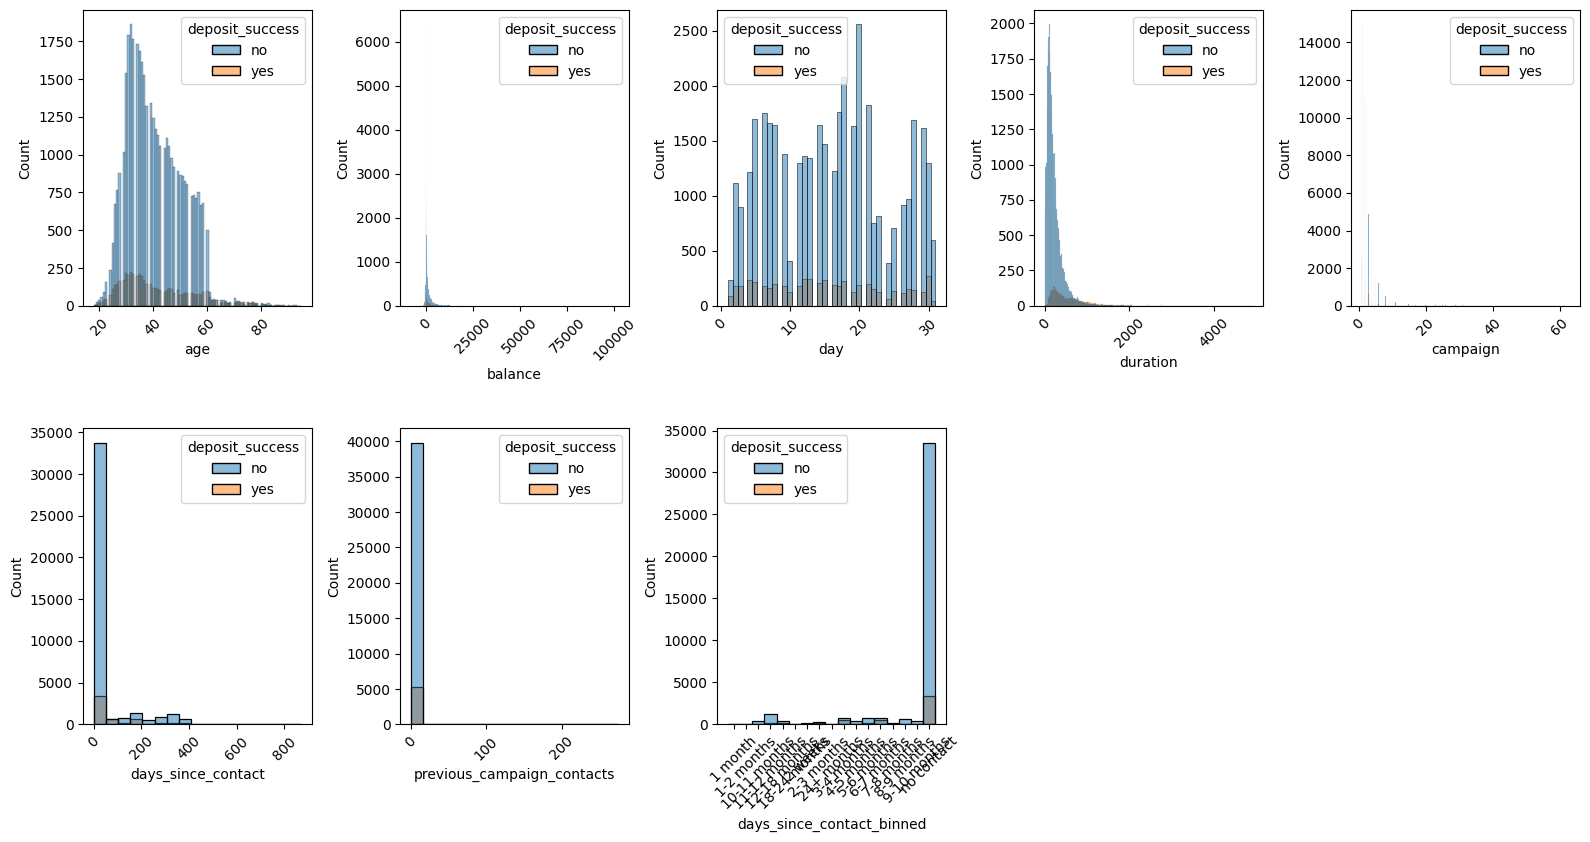

In [ ]:
# Histogram plot loop of variables selected for multiple regression analysis
# Note: visualization before data cleaning
df_hist = df.select_dtypes(exclude = 'object').columns
fig_hist = plt.figure(figsize=(16, 20))
deposit = df['deposit_success']

for i, col in enumerate(df_hist):

    ax = fig_hist.add_subplot(5, 5, i+1)

    sns.histplot(x = df[col], ax = ax, hue = deposit)
    plt.xticks(rotation = 45)
    fig_hist.tight_layout();

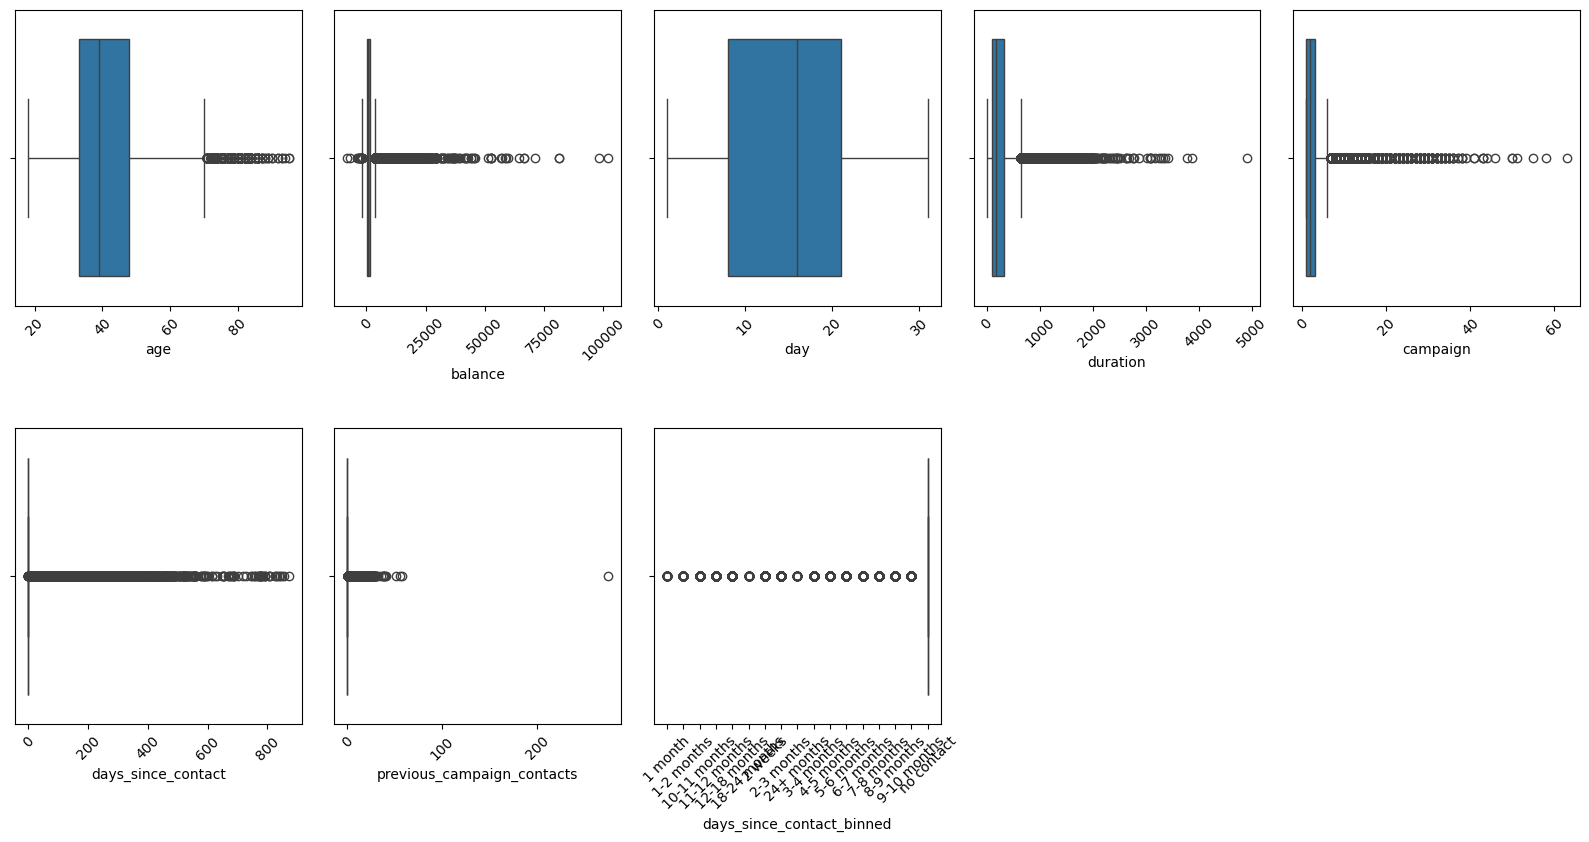

In [ ]:
# Box plot of numeric data
df_box = df.select_dtypes(exclude = 'object').columns
fig_hist = plt.figure(figsize=(16, 20))
deposit = df['deposit_success']


for i, col in enumerate(df_box):

    ax = fig_hist.add_subplot(5, 5, i+1)

    sns.boxplot(x = df[col], ax = ax)
    plt.xticks(rotation = 45)
    fig_hist.tight_layout();

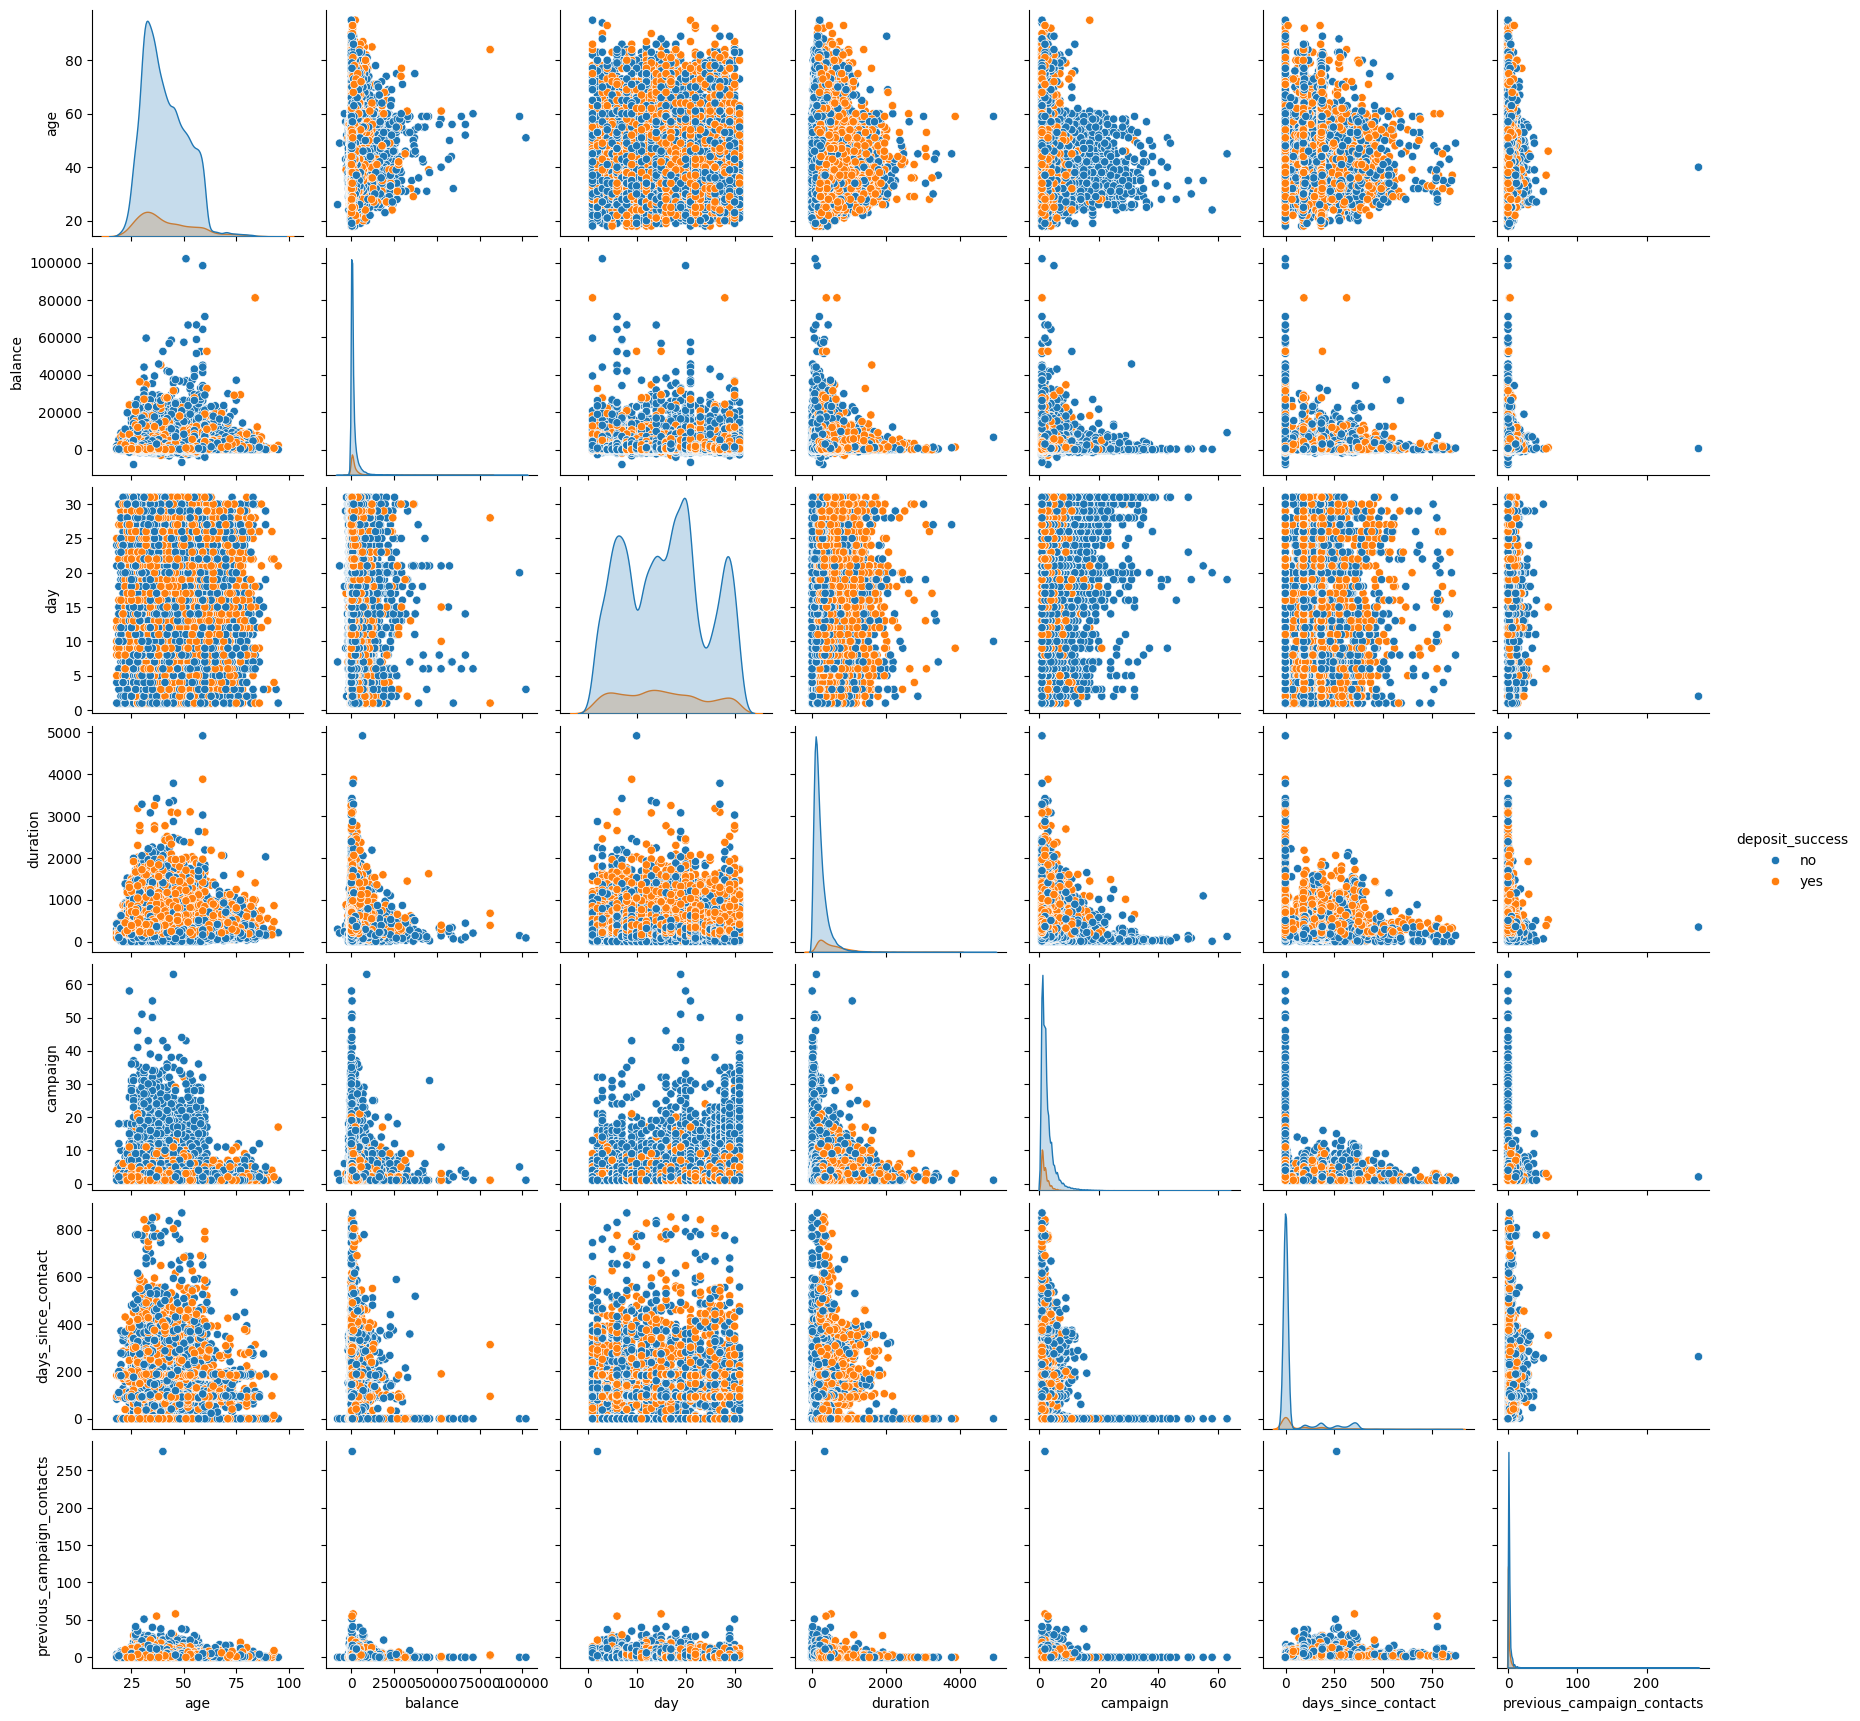

In [ ]:
# Pair plots
sns.pairplot(data = df, hue = 'deposit_success')

In [ ]:
# Create backup pre treatment of outliers
df_backup = df.copy(deep = True)

In [ ]:
# Keep copy of original df with all data previous to outlier treatment --- show quantity of outlier removal
all_data = df.copy(deep = True)

In [ ]:
# Value Counts of all deposits
df['deposit_success'].value_counts()

no     39919
yes     5289
Name: deposit_success, dtype: int64

In [ ]:
# Review Summary statistcs
df.describe()

,age,balance,day,duration,campaign,days_since_contact,previous_campaign_contacts
count,45208.000,45208.000,45208.000,45208.000,45208.000,45208.000,45208.000
mean,40.936,1362.229,15.806,258.180,2.764,40.201,0.580
std,10.619,3044.795,8.322,257.528,3.098,100.132,2.304
min,18.000,-8019.000,1.000,1.000,1.000,-1.000,0.000
25%,33.000,72.000,8.000,103.000,1.000,-1.000,0.000
50%,39.000,448.000,16.000,180.000,2.000,-1.000,0.000
75%,48.000,1428.000,21.000,319.000,3.000,-1.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,871.000,275.000


In [ ]:
# Drop numeric value column for newly created days contacted category
df.drop(columns = ['days_since_contact'], inplace = True)

In [ ]:
# Want to preserve as much of the minority class as possible, treat outliers based on values of yes summary statistics
# Isolate Noes
no = df[df['deposit_success'] == 'no']

# Isolate Yeses
yes = df[df['deposit_success'] == 'yes']

In [ ]:
# Summary stats of no
no.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,39919.000,39919.000,39919.000,39919.000,39919.000,39919.000
mean,40.839,1303.661,15.892,221.199,2.846,0.502
std,10.173,2974.223,8.295,207.382,3.212,2.257
min,18.000,-8019.000,1.000,1.000,1.000,0.000
25%,33.000,58.000,8.000,95.000,1.000,0.000
50%,39.000,417.000,16.000,164.000,2.000,0.000
75%,48.000,1345.000,21.000,279.000,3.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,275.000


In [ ]:
# Summary stats of yes
yes.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,5289.000,5289.000,5289.000,5289.000,5289.000,5289.000
mean,41.670,1804.268,15.158,537.295,2.141,1.170
std,13.498,3501.105,8.502,392.525,1.922,2.553
min,18.000,-3058.000,1.000,8.000,1.000,0.000
25%,31.000,210.000,8.000,244.000,1.000,0.000
50%,38.000,733.000,15.000,426.000,2.000,0.000
75%,50.000,2159.000,22.000,725.000,3.000,1.000
max,95.000,81204.000,31.000,3881.000,32.000,58.000


In [ ]:
# Percentage of total yes
print("Percentage of all Successful Deposits: " + str(round(len(yes)/len(df), 3)))

Percentage of all Successful Deposits: 0.117


<a name= "data-cleaning"></a>
# Data Cleaning
- Remove stastical outliers using IQR method for skewed distibutions
- Outliers removed based on stastistics of minority class (Term Deposit Succes = Yes)


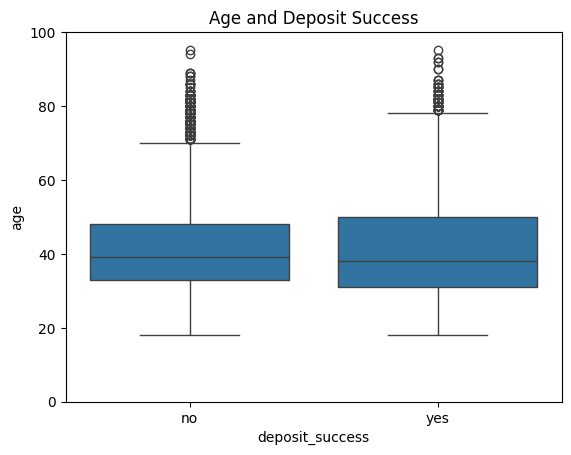

In [ ]:
# View Age box plots separated by deposit success
sns.boxplot(x = 'deposit_success', y = 'age', data = df);
plt.title("Age and Deposit Success")
plt.ylim((0, 100))
plt.show()

In [ ]:
# To preserve as much of the "yes" deposits, all outliers are removed based on iqr of confrimed "yes"
# Remove age outliers
q1 = yes['age'].quantile(0.25)
q3 = yes['age'].quantile(0.75)
iqr = q3 - q1
age_upper_fence = q3 + 1.5*iqr
age_lower_fence = q1 - 1.5*iqr

# Subset outliers
age_outliers = df[(df['age'] < age_lower_fence) | (df['age'] > age_upper_fence)]

# Confirm outliers subset
age_outliers.shape[0]

155

In [ ]:
# Remove outliers through filtering df
df = df[(df['age'] <= age_upper_fence) & (df['age'] >= age_lower_fence)]

# View shape of original and filtered
print("Original Data Dimensions: " + str(all_data.shape))
print("Cleaned Data Dimensions: " + str(df.shape))
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

Original Data Dimensions: (45208, 18)
Cleaned Data Dimensions: (45053, 17)
Total Outliers Removed: 155


In [ ]:
# Update yeses and noes after age removal
no = df[df['deposit_success'] == 'no']
yes = df[df['deposit_success'] == 'yes']

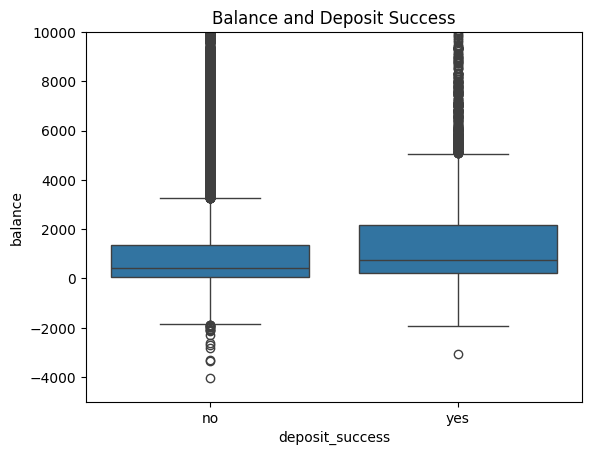

In [ ]:
# View Balance box plots separated by deposit success
sns.boxplot(x = 'deposit_success', y = 'balance', data = df);
plt.ylim((-5000, 10000))
plt.title("Balance and Deposit Success")
plt.show()

In [ ]:
no.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,39829.000,39829.000,39829.000,39829.000,39829.000,39829.000
mean,40.746,1302.774,15.895,221.153,2.847,0.502
std,9.991,2975.914,8.294,207.285,3.214,2.258
min,18.000,-8019.000,1.000,1.000,1.000,0.000
25%,33.000,58.000,8.000,95.000,1.000,0.000
50%,39.000,417.000,16.000,164.000,2.000,0.000
75%,48.000,1343.000,21.000,279.000,3.000,0.000
max,78.000,102127.000,31.000,4918.000,63.000,275.000


In [ ]:
yes.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,5224.000,5224.000,5224.000,5224.000,5224.000,5224.000
mean,41.155,1767.991,15.150,538.357,2.142,1.165
std,12.754,3143.443,8.501,393.587,1.917,2.550
min,18.000,-3058.000,1.000,8.000,1.000,0.000
25%,31.000,206.750,8.000,244.000,1.000,0.000
50%,38.000,732.000,15.000,427.000,2.000,0.000
75%,50.000,2152.750,22.000,726.000,3.000,1.000
max,78.000,52587.000,31.000,3881.000,32.000,58.000


In [ ]:
# To preserve as much of the "yes" deposits, all outliers are removed based on iqr of confrimed "yes"
# Remove balance outliers
q1 = yes['balance'].quantile(0.25)
q3 = yes['balance'].quantile(0.75)
iqr = q3 - q1
balance_upper_fence = q3 + 1.5*iqr
balance_lower_fence = q1 - 1.5*iqr

# Subset outliers
balance_outliers = df[(df['balance'] < balance_lower_fence) | (df['balance'] > balance_upper_fence)]

balance_outliers.shape[0]

2759

In [ ]:
# Remove outliers through filtering df
df = df[(df['balance'] <= balance_upper_fence) & (df['balance'] >= balance_lower_fence)]

# View shape of original and filtered
print("Original Data Dimensions: " + str(all_data.shape))
print("Cleaned Data Dimensions: " + str(df.shape))
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

Original Data Dimensions: (45208, 18)
Cleaned Data Dimensions: (42294, 17)
Total Outliers Removed: 2914


In [ ]:
# Update yeses and noes after age removal
no = df[df['deposit_success'] == 'no']
yes = df[df['deposit_success'] == 'yes']

In [ ]:
no.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,37484.000,37484.000,37484.000,37484.000,37484.000,37484.000
mean,40.587,763.875,15.875,220.468,2.853,0.497
std,9.924,1091.684,8.325,205.493,3.218,2.270
min,18.000,-2712.000,1.000,1.000,1.000,0.000
25%,33.000,45.000,8.000,95.000,1.000,0.000
50%,39.000,361.000,16.000,164.000,2.000,0.000
75%,48.000,1084.250,21.000,278.000,3.000,0.000
max,78.000,5068.000,31.000,3785.000,58.000,275.000


In [ ]:
yes.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,4810.000,4810.000,4810.000,4810.000,4810.000,4810.000
mean,40.925,1089.028,15.096,539.569,2.144,1.165
std,12.722,1229.582,8.501,393.905,1.928,2.571
min,18.000,-1944.000,1.000,8.000,1.000,0.000
25%,31.000,180.000,8.000,245.000,1.000,0.000
50%,38.000,618.000,15.000,429.000,2.000,0.000
75%,49.000,1655.000,21.000,727.000,3.000,1.000
max,78.000,5063.000,31.000,3881.000,32.000,58.000


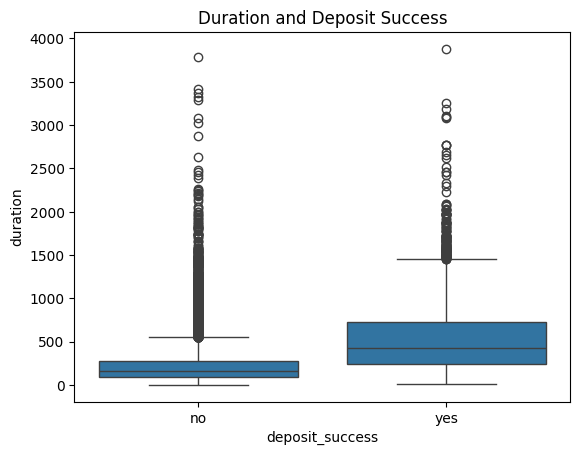

In [ ]:
# View Balance box plots separated by deposit success
sns.boxplot(x = 'deposit_success', y = 'duration', data = df);
plt.title("Duration and Deposit Success")
plt.show()

In [ ]:
# To preserve as much of the "yes" deposits, all outliers are removed based on iqr of confrimed "yes"
# Remove duration outliers
q1 = yes['duration'].quantile(0.25)
q3 = yes['duration'].quantile(0.75)
iqr = q3 - q1
duration_upper_fence = q3 + 1.5*iqr
duration_lower_fence = q1 - 1.5*iqr

# Subset outliers
duration_outliers = df[(df['duration'] < duration_lower_fence) | (df['duration'] > duration_upper_fence)]

duration_outliers.shape[0]

244

In [ ]:
# Remove outliers through filtering df
df = df[(df['duration'] <= duration_upper_fence) & (df['duration'] >= duration_lower_fence)]

# View shape of original and filtered
print("Original Data Dimensions: " + str(all_data.shape))
print("Cleaned Data Dimensions: " + str(df.shape))
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

Original Data Dimensions: (45208, 18)
Cleaned Data Dimensions: (42050, 17)
Total Outliers Removed: 3158


In [ ]:
# Update yeses and noes after duration removal
no = df[df['deposit_success'] == 'no']
yes = df[df['deposit_success'] == 'yes']

In [ ]:
no.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,37386.000,37386.000,37386.000,37386.000,37386.000,37386.000
mean,40.583,763.471,15.879,216.074,2.854,0.497
std,9.925,1091.744,8.325,185.203,3.220,2.272
min,18.000,-2712.000,1.000,1.000,1.000,0.000
25%,33.000,44.250,8.000,95.000,1.000,0.000
50%,39.000,361.000,16.000,163.000,2.000,0.000
75%,48.000,1082.000,21.000,277.000,3.000,0.000
max,78.000,5068.000,31.000,1449.000,58.000,275.000


In [ ]:
yes.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,4664.000,4664.000,4664.000,4664.000,4664.000,4664.000
mean,40.942,1093.122,15.065,499.369,2.133,1.184
std,12.798,1233.254,8.518,317.912,1.903,2.567
min,18.000,-1944.000,1.000,8.000,1.000,0.000
25%,31.000,181.000,8.000,241.000,1.000,0.000
50%,38.000,618.500,15.000,414.500,2.000,0.000
75%,49.000,1679.000,21.000,696.000,2.000,2.000
max,78.000,5063.000,31.000,1449.000,32.000,58.000


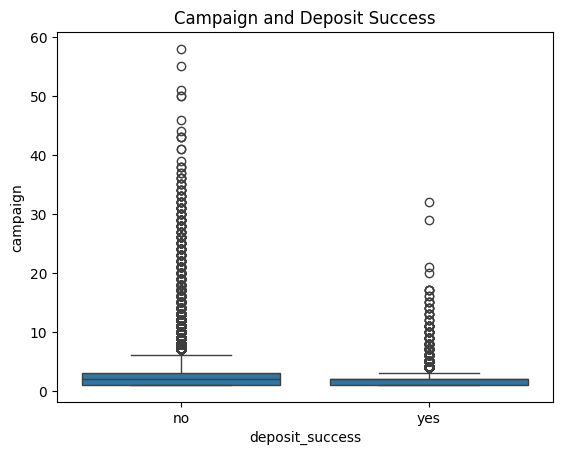

In [ ]:
# View Campaign box plots separated by deposit success
sns.boxplot(x = 'deposit_success', y = 'campaign', data = df);
plt.title("Campaign and Deposit Success")
plt.show()

In [ ]:
# To preserve as much of the "yes" deposits, all outliers are removed based on iqr of confrimed "yes"
# Remove campaign outliers
q1 = yes['campaign'].quantile(0.25)
q3 = yes['campaign'].quantile(0.75)
iqr = q3 - q1
campaign_upper_fence = q3 + 1.5*iqr
campaign_lower_fence = q1 - 1.5*iqr


# Subset outliers
campaign_outliers = df[(df['campaign'] < campaign_lower_fence) | (df['campaign'] > campaign_upper_fence)]

campaign_outliers.shape[0]

9034

In [ ]:
# Remove outliers through filtering df
df = df[(df['campaign'] <= campaign_upper_fence) & (df['campaign'] >= campaign_lower_fence)]

# View shape of original and filtered
print("Original Data Dimensions: " + str(all_data.shape))
print("Cleaned Data Dimensions: " + str(df.shape))
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

Original Data Dimensions: (45208, 18)
Cleaned Data Dimensions: (33016, 17)
Total Outliers Removed: 12192


In [ ]:
# Update yeses and noes after campaign removal
no = df[df['deposit_success'] == 'no']
yes = df[df['deposit_success'] == 'yes']

In [ ]:
no.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,28975.000,28975.000,28975.000,28975.000,28975.000,28975.000
mean,40.380,773.500,15.249,225.811,1.675,0.508
std,9.983,1093.408,8.221,184.930,0.732,2.325
min,18.000,-2712.000,1.000,1.000,1.000,0.000
25%,32.000,49.000,8.000,104.000,1.000,0.000
50%,39.000,372.000,15.000,172.000,2.000,0.000
75%,48.000,1101.000,21.000,288.000,2.000,0.000
max,78.000,5068.000,31.000,1449.000,3.000,275.000


In [ ]:
yes.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,4041.000,4041.000,4041.000,4041.000,4041.000,4041.000
mean,40.989,1096.738,14.864,477.798,1.572,1.247
std,12.958,1226.849,8.554,307.330,0.716,2.625
min,18.000,-1944.000,1.000,8.000,1.000,0.000
25%,31.000,188.000,8.000,232.000,1.000,0.000
50%,37.000,622.000,14.000,393.000,1.000,0.000
75%,50.000,1696.000,21.000,665.000,2.000,2.000
max,78.000,5063.000,31.000,1448.000,3.000,58.000


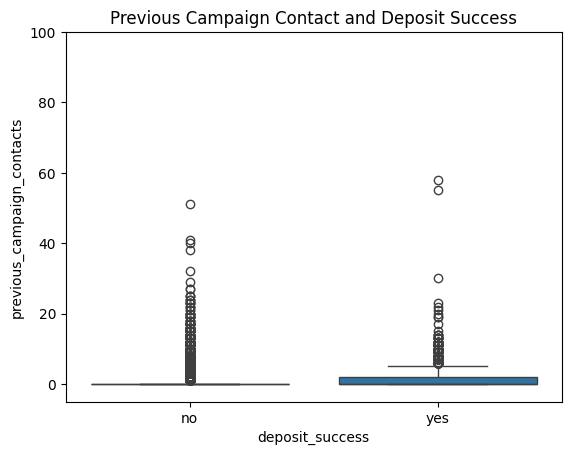

In [ ]:
# View Previous Contact box plots separated by deposit success
sns.boxplot(x = 'deposit_success', y = 'previous_campaign_contacts', data = df);
plt.ylim(-5, 100)
plt.title("Previous Campaign Contact and Deposit Success")
plt.show()

In [ ]:
# To preserve as much of the "yes" deposits, all outliers are removed based on iqr of confrimed "yes"
# Remove previous_campaign_contacts outliers
q1 = yes['previous_campaign_contacts'].quantile(0.25)
q3 = yes['previous_campaign_contacts'].quantile(0.75)
iqr = q3 - q1
previous_campaign_contacts_upper_fence = q3 + 1.5*iqr
previous_campaign_contacts_lower_fence = q1 - 1.5*iqr

# Subset outliers
previous_campaign_contacts_outliers = df[(df['previous_campaign_contacts'] < previous_campaign_contacts_lower_fence) | (df['previous_campaign_contacts'] > previous_campaign_contacts_upper_fence)]

previous_campaign_contacts_outliers.shape[0]

748

In [ ]:
# Remove outliers through filtering df
df = df[(df['previous_campaign_contacts'] <= previous_campaign_contacts_upper_fence) & (df['previous_campaign_contacts'] >= previous_campaign_contacts_lower_fence)]

# View shape of original and filtered
print("Original Data Dimensions: " + str(all_data.shape))
print("Cleaned Data Dimensions: " + str(df.shape))
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

Original Data Dimensions: (45208, 18)
Cleaned Data Dimensions: (32268, 17)
Total Outliers Removed: 12940


In [ ]:
df.describe()

,age,balance,day,duration,campaign,previous_campaign_contacts
count,32268.000,32268.000,32268.000,32268.000,32268.000,32268.000
mean,40.438,808.757,15.222,256.090,1.661,0.386
std,10.373,1113.603,8.266,219.775,0.730,0.966
min,18.000,-2712.000,1.000,1.000,1.000,0.000
25%,32.000,60.000,8.000,111.000,1.000,0.000
50%,38.000,394.000,15.000,188.000,2.000,0.000
75%,48.000,1158.000,21.000,323.250,2.000,0.000
max,78.000,5068.000,31.000,1449.000,3.000,5.000


In [ ]:
# Update yeses and noes after days since contact removal
nos = df[df['deposit_success'] == 'no']
yes = df[df['deposit_success'] == 'yes']

In [ ]:
# Percentage of total yes After cleaning
print("Percentage of all Successful Deposits After Cleaning: " + str(round(len(yes)/len(df),3)))

Percentage of all Successful Deposits After Cleaning: 0.118


In [ ]:
# Total outliers removed
print("Total Outliers Removed: " + str(all_data.shape[0] - df.shape[0]))

# Percent of all data removed
print("Percent of Data Removed: " + str((all_data.shape[0] - df.shape[0])/all_data.shape[0]))

Total Outliers Removed: 12940
Percent of Data Removed: 0.2862325252167758


In [ ]:
# Aggregate outlier dataframes into one outlier df
outliers = pd.concat([age_outliers, balance_outliers, duration_outliers, campaign_outliers, previous_campaign_contacts_outliers], ignore_index = True)

outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12940 entries, 0 to 12939
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   age                         12940 non-null  int64   
 1   job                         12940 non-null  object  
 2   marital                     12940 non-null  object  
 3   education                   12940 non-null  object  
 4   credit_default              12940 non-null  object  
 5   balance                     12940 non-null  int64   
 6   housing                     12940 non-null  object  
 7   loan                        12940 non-null  object  
 8   contact                     12940 non-null  object  
 9   day                         12940 non-null  int64   
 10  month                       12940 non-null  object  
 11  duration                    12940 non-null  int64   
 12  campaign                    12940 non-null  int64   
 13  previous_campaig

In [ ]:
# Copy clean df
df_clean = df.copy(deep = True)

In [ ]:
# View of summary statistics - categoricals
df.describe(include = 'all')

,age,job,marital,education,credit_default,balance,housing,loan,contact,day,month,duration,campaign,previous_campaign_contacts,previous_campaign_outcome,deposit_success,days_since_contact_binned
count,32268.000,32268,32268,32268,32268,32268.000,32268,32268,32268,32268.000,32268,32268.000,32268.000,32268.000,32268,32268,32268
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,4,2,17
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,unknown,no,no contact
freq,NaN,7152,19040,16996,31684,NaN,18516,26910,20772,NaN,10560,NaN,NaN,NaN,26404,28451,26401
mean,40.438,NaN,NaN,NaN,NaN,808.757,NaN,NaN,NaN,15.222,NaN,256.090,1.661,0.386,NaN,NaN,NaN
std,10.373,NaN,NaN,NaN,NaN,1113.603,NaN,NaN,NaN,8.266,NaN,219.775,0.730,0.966,NaN,NaN,NaN
min,18.000,NaN,NaN,NaN,NaN,-2712.000,NaN,NaN,NaN,1.000,NaN,1.000,1.000,0.000,NaN,NaN,NaN
25%,32.000,NaN,NaN,NaN,NaN,60.000,NaN,NaN,NaN,8.000,NaN,111.000,1.000,0.000,NaN,NaN,NaN
50%,38.000,NaN,NaN,NaN,NaN,394.000,NaN,NaN,NaN,15.000,NaN,188.000,2.000,0.000,NaN,NaN,NaN
75%,48.000,NaN,NaN,NaN,NaN,1158.000,NaN,NaN,NaN,21.000,NaN,323.250,2.000,0.000,NaN,NaN,NaN


<a name= "model-preperation"></a>
# Model Preperation
- Shapiro-Wilk Test for normality
  - Test not required for logistic or random forest classification, but required for Capstone project
- One-hot encode categorical data
- 80/20 Train-Test split
- Scale data with Minmax scaler
- Apply synthetic minority oversampling technique (SMOTE)



In [ ]:
# Shapiro Wilk test for normality
for col in df.columns:
  if df[col].dtype == 'int64':
    print(f"Shapiro-Wilk test for {col}: {shapiro(df[col])}")

Shapiro-Wilk test for age: ShapiroResult(statistic=0.9642646312713623, pvalue=0.0)
Shapiro-Wilk test for balance: ShapiroResult(statistic=0.817630410194397, pvalue=0.0)
Shapiro-Wilk test for day: ShapiroResult(statistic=0.9577406644821167, pvalue=0.0)
Shapiro-Wilk test for duration: ShapiroResult(statistic=0.8036201596260071, pvalue=0.0)
Shapiro-Wilk test for campaign: ShapiroResult(statistic=0.7605543732643127, pvalue=0.0)
Shapiro-Wilk test for previous_campaign_contacts: ShapiroResult(statistic=0.46214306354522705, pvalue=0.0)


In [ ]:
# Logistic Regression nor Random Forest require normal distributions, therefore data will not be transformed
# Change deposit success into numeric values 0 = no, 1 = yes
df['deposit_success'].replace({'no': 0, 'yes': 1}, inplace = True)

# Confirm change through value counts
df['deposit_success'].value_counts()

0    28451
1     3817
Name: deposit_success, dtype: int64

In [ ]:
# One Hot encode all categorical data using get dummies
df_onehot = pd.get_dummies(df)

In [ ]:
# Confirm dummy variables
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32268 entries, 0 to 45207
Data columns (total 68 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   age                                     32268 non-null  int64
 1   balance                                 32268 non-null  int64
 2   day                                     32268 non-null  int64
 3   duration                                32268 non-null  int64
 4   campaign                                32268 non-null  int64
 5   previous_campaign_contacts              32268 non-null  int64
 6   deposit_success                         32268 non-null  int64
 7   job_admin.                              32268 non-null  uint8
 8   job_blue-collar                         32268 non-null  uint8
 9   job_entrepreneur                        32268 non-null  uint8
 10  job_housemaid                           32268 non-null  uint8
 11  job_management 

In [ ]:
# Split into df_train and df_test as MinMaxScaler need only apply to train set without influence of test set
y = df_onehot['deposit_success']
X = df_onehot.drop(columns = ['deposit_success'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 61, stratify = y)

print("X Train Shape: " + str(X_train.shape))
print("y Train Shape: " + str(y_train.shape))
print("X Test Shape: " + str(X_test.shape))
print("y Test Shape: " + str(y_test.shape))

X Train Shape: (25814, 67)
y Train Shape: (25814,)
X Test Shape: (6454, 67)
y Test Shape: (6454,)


In [ ]:
# Import and instantiate MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [ ]:
# Due to imbalance of classification, use SMOTE
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state = 61)

# Apply SMOTE to training dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

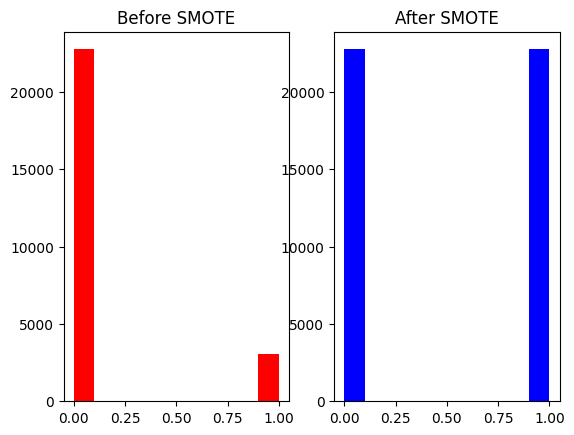

In [ ]:
# Visualize imbalance before and after SMOTE
fig, ax = plt.subplots(1, 2)
ax[0].hist(y_train, color = 'red')
ax[1].hist(y_train_smote, color = 'blue')
ax[0].set_title("Before SMOTE")
ax[1].set_title("After SMOTE")
plt.show()

In [ ]:
# Classificaiton reports will yeild coefficients and feature names as numnbers, want to get names of columns for downstream analyissi
# Gather column names from one hot encoded - using df_2 for ease
df_2 = df_onehot.copy(deep = True)

# drop target column
df_2 = df_2.drop(columns = ['deposit_success'])

# Get list of columnn names
columns = df_2.columns


<a name= "logistic-classifier-model"></a>
# Logistic Classifier Model
- Hyperparameter tuning using GridSearchCV
  - cross validation using Stratified K-fold to best represent minority class
- Fit model to optimized parameters


In [ ]:
# Imoport logistic regression
from sklearn.linear_model import LogisticRegression

# Instantiate lr for model
lr = LogisticRegression(random_state = 61, n_jobs = -1)

In [ ]:
# GridSearchCV for Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Define parameters, look for best solver
lr_params = {'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}

# Cross validation using StratifiedKFold
kf = StratifiedKFold(n_splits = 5, shuffle = False)

# Employ logistic regression GridSearchCV using stratified k-fold cross validation and f1 scoring
lr_cv = GridSearchCV(lr, lr_params, cv = kf, n_jobs = -1, scoring = 'f1')

In [ ]:
# Fit model to scaled data, not SMOTE data
lr_grid_fit = lr_cv.fit(X_train_scaled, y_train)

# Print results
print("Best LR Parameters: " + str(lr_grid_fit.best_params_))
print("Best LR Score: " + str(lr_grid_fit.best_score_))

Best LR Parameters: {'solver': 'liblinear'}
Best LR Score: 0.45788023564701374


In [ ]:
# Define best regressor based on GridSearchCV results

# Identify the best estimatora
lr_best = lr_grid_fit.best_estimator_

lr_best

LogisticRegression(n_jobs=-1, random_state=61, solver='liblinear')

In [ ]:
# Fit model
smote_model = lr_best.fit(X_train_smote, y_train_smote)

# Make predictions
pred_lr_smote = smote_model.predict(X_test_scaled)


<a name= "random-forest-model"></a>
# Random Forest Model
- Hyperparameter tuning using GridSearchCV
  - cross validation using Stratified K-fold to best represent minority class
- Fit model to optimized parameters


In [ ]:
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Instantiate regressor
rf = RandomForestClassifier(random_state = 61, n_jobs = -1)

# Use a stratified k-fold for cross validation
kf = StratifiedKFold(n_splits=5, shuffle = False)

In [ ]:
# Employ GridSearchCV for hyperparameter tuning and Random Forest optimization
from sklearn.model_selection import GridSearchCV

# Define parameters, look for optimized max_depth, max_features, n_estimators
params = {'criterion': ['entropy', 'ginni'], 'max_depth': [2, 4, 6, 10, 12], 'max_features': [2, 4, 6], 'n_estimators': [50, 80, 100], 'random_state': [61]}

In [ ]:
# Random Forest hyperparameter tuning
# Employ random forest GridSearchCV using stratified k-fold cross validation and f1 scoring
rf_cv = GridSearchCV(rf, params, cv = kf, n_jobs = -1, scoring = 'f1')

# Fit model
grid_fit = rf_cv.fit(X_train_scaled, y_train)

# Print results
print("Best Parameters: " + str(grid_fit.best_params_))
print("Best Score: " + str(grid_fit.best_score_))

Best Parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 6, 'n_estimators': 50, 'random_state': 61}
Best Score: 0.2867825432299432


In [ ]:
# Define best regressor based on GridSearchCV results
rf_best = grid_fit.best_estimator_

rf_best

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=6,
                       n_estimators=50, n_jobs=-1, random_state=61)

In [ ]:
# Fit best model
model_rf = rf_best.fit(X_train_smote, y_train_smote)


In [ ]:
# Best Predictions
pred_rf = model_rf.predict(X_test_scaled)

<a name= "logistic-model-results"></a>
# Logistic Model Results
- Classification report
  - F1 metric (goal to have a value that exceeds 0.3)
- Influential features
- Plot of influential features



In [ ]:
# Import classification report
from sklearn.metrics import classification_report

# Logistic regressino classification reportt
class_report_lr = classification_report(y_test, pred_lr_smote)

print(class_report_lr)

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      5691
           1       0.41      0.80      0.54       763

    accuracy                           0.84      6454
   macro avg       0.69      0.82      0.72      6454
weighted avg       0.90      0.84      0.86      6454



In [ ]:
# Gather feature importance from SMOTE logistic regression model
importance = smote_model.coef_[0]


In [ ]:
# Create new df for feature importance
lr_feature_importance = pd.DataFrame({'feature': [x for x in range(len(importance))], 'importance': importance})

lr_feature_importance

,feature,importance
0,0,0.160
1,1,0.844
2,2,0.015
3,3,10.034
4,4,-0.589
...,...,...
62,62,0.429
63,63,-1.358
64,64,-0.401
65,65,-0.250


In [ ]:
# Add feature names to df
lr_feature_importance = lr_feature_importance.assign(feature_names = columns)

lr_feature_importance

,feature,importance,feature_names
0,0,0.160,age
1,1,0.844,balance
2,2,0.015,day
3,3,10.034,duration
4,4,-0.589,campaign
...,...,...,...
62,62,0.429,days_since_contact_binned_6-7 months
63,63,-1.358,days_since_contact_binned_7-8 months
64,64,-0.401,days_since_contact_binned_8-9 months
65,65,-0.250,days_since_contact_binned_9-10 months


In [ ]:
# Filter df for sorting
lr_sort = lr_feature_importance[['feature_names', 'importance']]

# Get absolute values of importances
lr_sort['abs_importance'] = lr_feature_importance['importance'].abs()

lr_sort

,feature_names,importance,abs_importance
0,age,0.160,0.160
1,balance,0.844,0.844
2,day,0.015,0.015
3,duration,10.034,10.034
4,campaign,-0.589,0.589
...,...,...,...
62,days_since_contact_binned_6-7 months,0.429,0.429
63,days_since_contact_binned_7-8 months,-1.358,1.358
64,days_since_contact_binned_8-9 months,-0.401,0.401
65,days_since_contact_binned_9-10 months,-0.250,0.250


In [ ]:
# Sort features relative to absolute value of importances
lr_sort = lr_sort.sort_values(by = 'abs_importance', ascending = False)

# View the top 10
lr_sort[['feature_names', 'importance']].head(10)

,feature_names,importance
3,duration,10.034
58,days_since_contact_binned_24+ months,2.959
41,month_mar,1.967
38,month_jan,-1.753
33,contact_unknown,-1.564
44,month_oct,1.460
52,days_since_contact_binned_10-11 months,-1.366
63,days_since_contact_binned_7-8 months,-1.358
39,month_jul,-1.321
48,previous_campaign_outcome_success,1.285


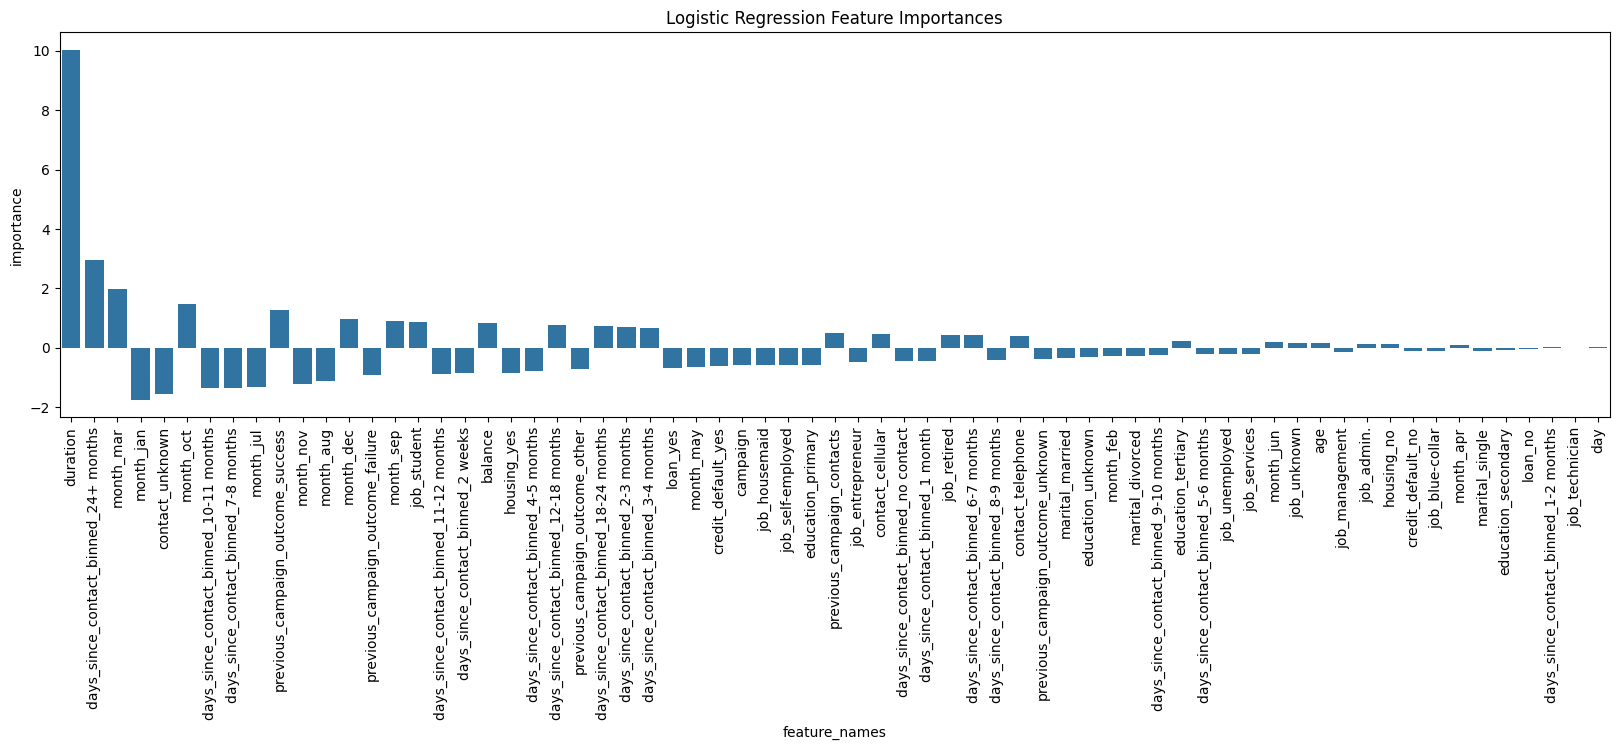

In [ ]:
# Plot bar plot of feature importances
plt.figure(figsize=(20, 5))
sns.barplot(x = 'feature_names', y = 'importance', data = lr_sort);
plt.xticks(rotation = 90)
plt.title("Logistic Regression Feature Importances")
plt.show()

<a name= "random-forest-model-results"></a>
# Random Forest Model Results
- Classification report
  - F1 metric (goal to have a value that exceeds 0.3)
- Influential features
- Plot of influential features



In [ ]:
# Confusiton Matrix and Classification Report
class_report_rf = classification_report(y_test, pred_rf)


print('\n')
print("Classification Report", '\n')
print(class_report_rf)



Classification Report 

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      5691
           1       0.42      0.75      0.54       763

    accuracy                           0.85      6454
   macro avg       0.69      0.81      0.73      6454
weighted avg       0.90      0.85      0.87      6454



In [ ]:
# Create new dataframe of features and importances from random forest
rf_feature_importances = pd.DataFrame({'feature': [x for x in range(len(model_rf.feature_importances_))], 'importance': model_rf.feature_importances_})


rf_feature_importances

,feature,importance
0,0,0.028
1,1,0.040
2,2,0.026
3,3,0.325
4,4,0.040
...,...,...
62,62,0.011
63,63,0.000
64,64,0.002
65,65,0.001


In [ ]:
# Add feature names to df to correspond to their importance values
rf_feature_importances = rf_feature_importances.assign(feature_names = columns)

# Create new df with just featuer and importance values
rf_sort = rf_feature_importances[['feature_names', 'importance']]

# Sort random forest feature importance in descending order
rf_sort = rf_sort.sort_values(by = 'importance', ascending = False)

# View top-10 feature importances of random forest classifier
rf_sort.head(10)

,feature_names,importance
3,duration,0.325
48,previous_campaign_outcome_success,0.054
33,contact_unknown,0.054
31,contact_cellular,0.042
1,balance,0.040
4,campaign,0.040
27,housing_no,0.036
28,housing_yes,0.031
0,age,0.028
2,day,0.026


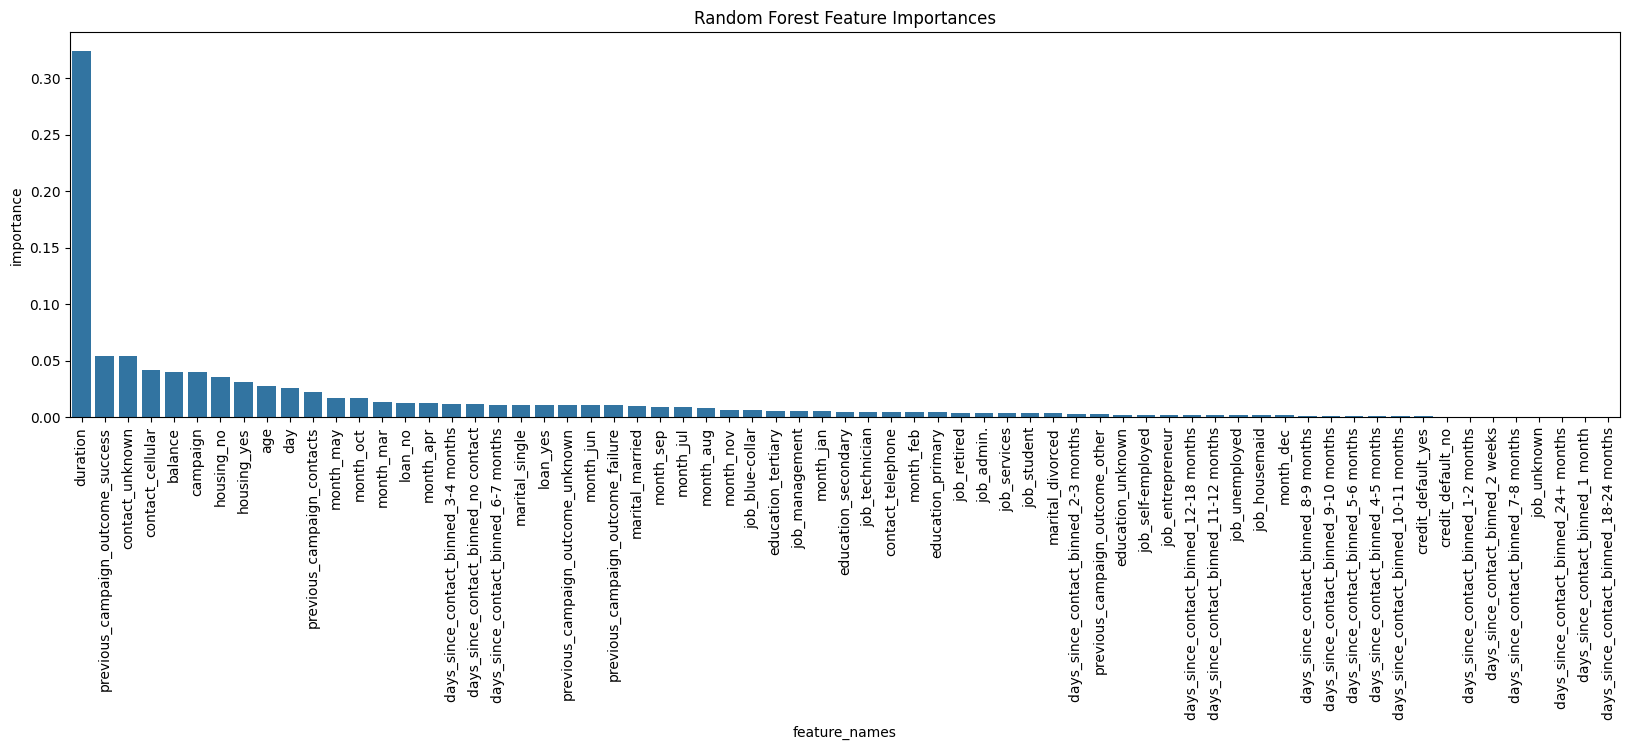

In [ ]:
# Plot barplot of random forest feature importances
plt.figure(figsize=(20, 5))
sns.barplot(x = 'feature_names', y = 'importance', data = rf_sort);
plt.xticks(rotation = 90)
plt.title("Random Forest Feature Importances")
plt.show()

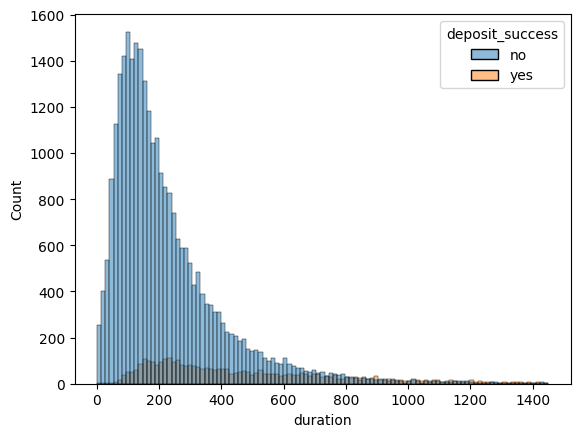

In [ ]:
sns.histplot(x = 'duration', data = df_clean, hue = 'deposit_success');

Text(0.5, 1.0, 'Duration Compared to Term Deposit Success')

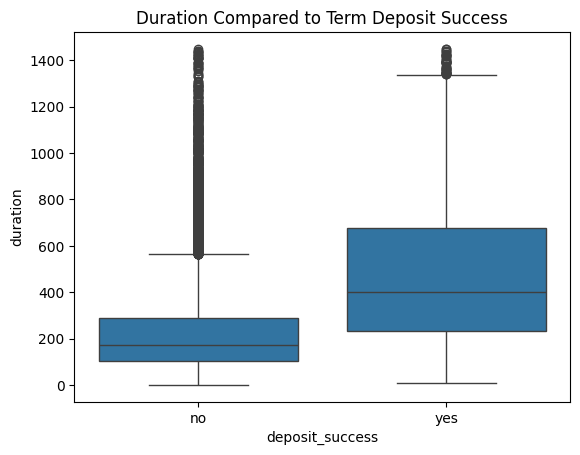

In [ ]:
# View of duration relative to term deposit success (cleaned dataframe)
sns.boxplot(x = 'deposit_success', y = 'duration', data = df_clean);
plt.title("Duration Compared to Term Deposit Success")

In [ ]:
### END ###